In [1]:
pip install pyspark

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
spark = SparkSession.builder.appName("Game_Recommendation_System").getOrCreate()

In [4]:
# Reading Data
recom = spark.read.csv("/content/recommendations.csv", header=True, inferSchema=True)
games = spark.read.csv("/content/games.csv", header=True, inferSchema=True)

In [5]:
games.show(10)

+------+--------------------+------------+----+-----+-----+---------------+--------------+------------+-----------+--------------+--------+----------+
|app_id|               title|date_release| win|  mac|linux|         rating|positive_ratio|user_reviews|price_final|price_original|discount|steam_deck|
+------+--------------------+------------+----+-----+-----+---------------+--------------+------------+-----------+--------------+--------+----------+
| 13500|Prince of Persia:...|  2008-11-21|true|false|false|  Very Positive|            84|        2199|       9.99|          9.99|     0.0|      true|
| 22364|BRINK: Agents of ...|  2011-08-03|true|false|false|       Positive|            85|          21|       2.99|          2.99|     0.0|      true|
|113020|Monaco: What's Yo...|  2013-04-24|true| true| true|  Very Positive|            92|        3722|      14.99|         14.99|     0.0|      true|
|226560|  Escape Dead Island|  2014-11-18|true|false|false|          Mixed|            61|    

In [6]:
recom.show(10)

+-------+-------+-----+----------+--------------+-----+-------+---------+
| app_id|helpful|funny|      date|is_recommended|hours|user_id|review_id|
+-------+-------+-----+----------+--------------+-----+-------+---------+
| 975370|      0|    0|2022-12-12|          true| 36.3|  47199|        0|
| 304390|      4|    0|2017-02-17|         false| 11.5|   2376|        1|
|1085660|      2|    0|2019-11-17|          true|336.5| 230757|        2|
| 703080|      0|    0|2022-09-23|          true| 27.4| 235736|        3|
| 526870|      0|    0|2021-01-10|          true|  7.9|  21721|        4|
| 306130|      0|    0|2021-10-10|          true|  8.6|  41543|        5|
| 238960|      0|    0|2017-11-25|          true|538.8|  80787|        6|
|    730|      0|    0|2021-11-30|         false|157.5|  57879|        7|
| 255710|      0|    0|2021-05-21|          true| 18.7| 321815|        8|
| 289070|      0|    0|2020-05-26|          true|397.5| 412440|        9|
+-------+-------+-----+----------+----

In [7]:
games.printSchema()

root
 |-- app_id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- date_release: date (nullable = true)
 |-- win: boolean (nullable = true)
 |-- mac: boolean (nullable = true)
 |-- linux: boolean (nullable = true)
 |-- rating: string (nullable = true)
 |-- positive_ratio: integer (nullable = true)
 |-- user_reviews: integer (nullable = true)
 |-- price_final: double (nullable = true)
 |-- price_original: double (nullable = true)
 |-- discount: double (nullable = true)
 |-- steam_deck: boolean (nullable = true)



In [8]:
recom.printSchema()

root
 |-- app_id: integer (nullable = true)
 |-- helpful: integer (nullable = true)
 |-- funny: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- is_recommended: boolean (nullable = true)
 |-- hours: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- review_id: integer (nullable = true)



In [9]:
# Deleting unnecessary columns
dropg = ['date_release', 'discount', 'steam_deck', 'price_original']
dropr = ['helpful', 'funny', 'date', 'review_id']

games = games.drop(*dropg)
recom = recom.drop(*dropr)

In [10]:
games.show(10)

+------+--------------------+----+-----+-----+---------------+--------------+------------+-----------+
|app_id|               title| win|  mac|linux|         rating|positive_ratio|user_reviews|price_final|
+------+--------------------+----+-----+-----+---------------+--------------+------------+-----------+
| 13500|Prince of Persia:...|true|false|false|  Very Positive|            84|        2199|       9.99|
| 22364|BRINK: Agents of ...|true|false|false|       Positive|            85|          21|       2.99|
|113020|Monaco: What's Yo...|true| true| true|  Very Positive|            92|        3722|      14.99|
|226560|  Escape Dead Island|true|false|false|          Mixed|            61|         873|      14.99|
|249050|Dungeon of the EN...|true| true|false|  Very Positive|            88|        8784|      11.99|
|250180|        METAL SLUG 3|true|false|false|  Very Positive|            90|        5579|       7.99|
|253980|             Enclave|true| true| true|Mostly Positive|           

In [11]:
recom.show(10)

+-------+--------------+-----+-------+
| app_id|is_recommended|hours|user_id|
+-------+--------------+-----+-------+
| 975370|          true| 36.3|  47199|
| 304390|         false| 11.5|   2376|
|1085660|          true|336.5| 230757|
| 703080|          true| 27.4| 235736|
| 526870|          true|  7.9|  21721|
| 306130|          true|  8.6|  41543|
| 238960|          true|538.8|  80787|
|    730|         false|157.5|  57879|
| 255710|          true| 18.7| 321815|
| 289070|          true|397.5| 412440|
+-------+--------------+-----+-------+
only showing top 10 rows



In [12]:
# Check null values in Data
null_games = games.select([count(when(col(i).isNull(),i)).alias(i) for i in games.columns])
null_games.show()

+------+-----+---+---+-----+------+--------------+------------+-----------+
|app_id|title|win|mac|linux|rating|positive_ratio|user_reviews|price_final|
+------+-----+---+---+-----+------+--------------+------------+-----------+
|     0|    0|  0|  0|    0|     0|             0|           0|          0|
+------+-----+---+---+-----+------+--------------+------------+-----------+



In [13]:
null_recom = recom.select([count(when(col(i).isNull(),i)).alias(i) for i in recom.columns])
null_recom.show()

+------+--------------+-----+-------+
|app_id|is_recommended|hours|user_id|
+------+--------------+-----+-------+
|     0|             0|    0|      0|
+------+--------------+-----+-------+



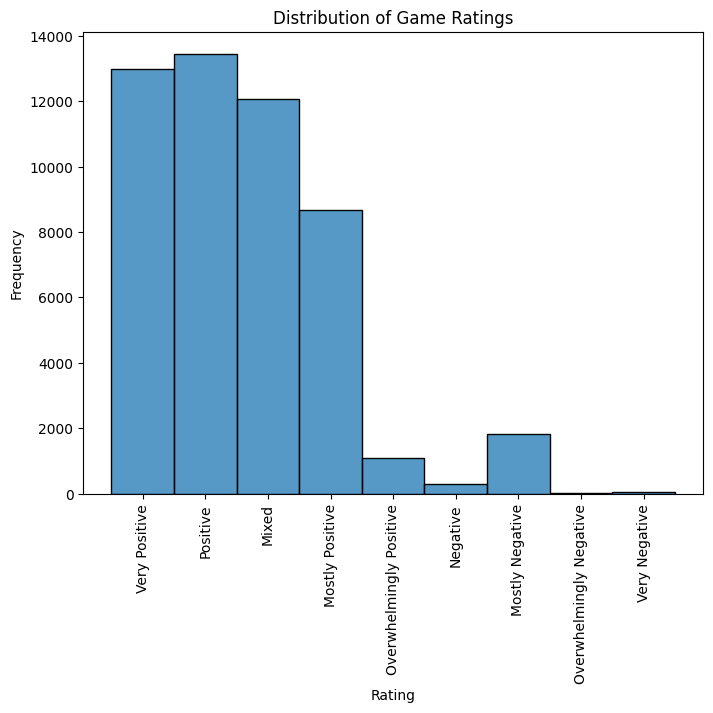

In [25]:
# Visualizing the distribution of game ratings

games_pandas = games.toPandas()

plt.figure(figsize=(8, 6))
sns.histplot(games_pandas['rating'], bins=20)
plt.title("Distribution of Game Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

In [68]:
# Demo inputs
#  Grand Theft Auto V
#  Dying Light 2 Stay Human
#  Cyberpunk 2077
#  Red Dead Redemption 2
# Jurassic World Evolution 2
# STAR WARS™: The Old Republic™
# The Elder Scrolls® Online
# FINAL FANTASY XIV Online
# Farming Simulator 22

In [101]:
# Taking a input game
input_game_name = input("Enter the name of the game: ")
target_app_id = games.filter(games.title == input_game_name).collect()
target_app_id = target_app_id[0]["app_id"]
target_app_id

Enter the name of the game: FINAL FANTASY XIV Online


39210

In [102]:
filtered_games = games.filter(games.app_id == target_app_id)

filtered_games.show()

+------+--------------------+----+-----+-----+-------------+--------------+------------+-----------+
|app_id|               title| win|  mac|linux|       rating|positive_ratio|user_reviews|price_final|
+------+--------------------+----+-----+-----+-------------+--------------+------------+-----------+
| 39210|FINAL FANTASY XIV...|true|false|false|Very Positive|            88|       60787|      19.99|
+------+--------------------+----+-----+-----+-------------+--------------+------------+-----------+



In [103]:
# Checking how many users have played this game(app_id) from recom table
target_user_ids = recom.filter(recom.app_id == target_app_id)
target_user_ids.show(5)

+------+--------------+-----+--------+
|app_id|is_recommended|hours| user_id|
+------+--------------+-----+--------+
| 39210|          true|123.1| 4835698|
| 39210|          true|169.4| 6526765|
| 39210|          true|  5.8| 2147622|
| 39210|          true|  9.0|10109373|
| 39210|          true| 37.2| 5806180|
+------+--------------+-----+--------+
only showing top 5 rows



In [104]:
# Sorting DataFrame(usr_id) by hours
#To get the players who played the game more. Because they liked the game more so they can give more accurate recommendation
# Selecting top 1000 players
usr_id = target_user_ids.orderBy("hours", ascending=False).limit(1000)
usr_id.show(5)

+------+--------------+-----+--------+
|app_id|is_recommended|hours| user_id|
+------+--------------+-----+--------+
| 39210|          true|999.9| 6550629|
| 39210|         false|999.8| 6310334|
| 39210|          true|999.7| 6110833|
| 39210|          true|999.7|12148270|
| 39210|          true|999.6| 6157273|
+------+--------------+-----+--------+
only showing top 5 rows



In [105]:
# Extracting user_id of these users
users = usr_id.select("user_id").rdd.flatMap(lambda x: x).collect()

In [106]:
# Checking if recom['user_id'] isin users Series
# Filter recommendations based on selected users
final_df = recom.filter(recom.user_id.isin(users))
final_df.show(5)

+-------+--------------+-----+--------+
| app_id|is_recommended|hours| user_id|
+-------+--------------+-----+--------+
|  39210|          true|928.5| 3972621|
|    730|          true|608.7|10073658|
|1284210|          true|  0.2| 1061500|
|  39210|          true|971.9|  613706|
|  39210|          true|995.6| 3715030|
+-------+--------------+-----+--------+
only showing top 5 rows



In [107]:
# Counting how many users have played these games
# Checing how many users have played a game & taking the top 7 games
recom_games = final_df.groupBy("app_id").count().orderBy("count", ascending=False).limit(7).collect()
recom_games

[Row(app_id=39210, count=1000),
 Row(app_id=306130, count=20),
 Row(app_id=1091500, count=13),
 Row(app_id=435150, count=12),
 Row(app_id=1245620, count=11),
 Row(app_id=1085660, count=11),
 Row(app_id=238960, count=11)]

In [108]:
# Extract app_id from recom_games
apps = [row["app_id"] for row in recom_games[1:]]
apps

[306130, 1091500, 435150, 1245620, 1085660, 238960]

In [109]:
output = games.filter(games.app_id.isin(apps))

In [110]:
# Filters
cond = input("Do you want to add filters(Os,Price,None): ")

if cond.lower() == 'os':
    os = input("Enter preferred Os system(windows/mac/linux/any): ").lower()
    if(os=='windows'):
      os = 'win'

    if os in ['win', 'mac', 'linux', 'any']:
        if os == 'any':
            output.show(truncate=False)
        else:
            os_col = os if os != 'any' else 'win'
            filtered_titles = output.filter(output[os_col] == True)
            if filtered_titles.count() == 0:
                print("No Games found")
            else:
                filtered_titles.show(truncate=False)
    else:
        print("Please enter a valid OS option.")

elif cond.lower() == 'price':
    price = float(input("Enter price range: "))
    filtered_titles = output.filter(output.price_final <= price)
    filtered_titles.show(truncate=False)

elif cond.lower() == 'none':
    output.show(truncate=False)

else:
    print("Please enter valid filter options.")

Do you want to add filters(Os,Price,None): none
+-------+---------------------------------------------+----+-----+-----+-----------------------+--------------+------------+-----------+
|app_id |title                                        |win |mac  |linux|rating                 |positive_ratio|user_reviews|price_final|
+-------+---------------------------------------------+----+-----+-----+-----------------------+--------------+------------+-----------+
|238960 |Path of Exile                                |true|true |false|Very Positive          |87            |202504      |0.0        |
|306130 |The Elder Scrolls® Online                    |true|true |false|Very Positive          |83            |111642      |19.99      |
|435150 |Divinity: Original Sin 2 - Definitive Edition|true|true |false|Overwhelmingly Positive|95            |142298      |44.99      |
|1085660|Destiny 2                                    |true|false|false|Very Positive          |82            |549598      |0.0   